# Libraries

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import os
import itertools
import traceback
import sys
import time

import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm.auto import trange
import matplotlib

# custom libraries
from utils import *

In [2]:
from sklearn.cluster import OPTICS as optics

# Data

In [3]:
data_path = '../../ARC-master/data'

submission_sample = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

train_tasks, eval_tasks, test_tasks = read_tasks(data_path)

with open('mapping_task_ids.pkl', 'rb') as f:
    mapping_task_ids = pickle.load(f)
    
mapping_train_tasks = {task_id: train_tasks[task_id] for task_id in mapping_task_ids['train']}
mapping_eval_tasks = {task_id: eval_tasks[task_id] for task_id in mapping_task_ids['eval']}
mapping_test_tasks = {task_id: test_tasks[task_id] for task_id in mapping_task_ids['test']}

# Adapted features (no clustering)

In [4]:
def get_adapted_square_features(img_fts):
    new_img_fts = img_fts.copy()
    new_img_fts['row_perc'] = img_fts['row'] / img_fts['row'].max()
    new_img_fts['column_perc'] = img_fts['column'] / img_fts['column'].max()
    new_img_fts['row_is_even'] = (img_fts['row'] % 2 == 0).astype(int)
    new_img_fts['column_is_even'] = (img_fts['column'] % 2 == 0).astype(int)
    new_img_fts['color_is_nonblack'] = (img_fts['color'] != 0).astype(int)
    
    return new_img_fts

# Clustering

In [26]:
def parse_image_for_clusters(image):
    fts = {
        'row': [],
        'column': [],
        'color': [],
        'is_color': [],
    }
    for row in range(len(image)):
        for col in range(len(image[0])):
            fts['row'].append(row)
            fts['column'].append(col)
            fts['color'].append(image[row][col])
            fts['is_color'].append(int(image[row][col] > 0))
    
    return pd.DataFrame(fts)

def get_all_list_combinations(l):
    return [list(subset) for L in range(1, len(l)+1) for subset in itertools.combinations(l, L)]

In [11]:
def get_square_surrounding_squares(r, c, max_r, max_c):
    # surrounding squares of a square
    surr_sq = np.array([(r-1,c-1), (r-1,c), (r-1,c+1), (r,c-1), (r,c+1), (r+1,c-1), (r+1,c), (r+1,c+1)])
    # return (x,y) of squares inside the image
    return surr_sq[(surr_sq[:, 0] >= 0) & (surr_sq[:, 1] >= 0) &
                   (surr_sq[:, 0] <= max_r) & (surr_sq[:, 1] <= max_c)]


def get_cluster_surounding_squares_dist_1(img_fts, clust):
    # surrounding squares in cluster
    surrs = []
    for r, c in clust[['row', 'column']].values:
        surrs.extend(get_square_surrounding_squares(r, c, img_fts['row'].max(), img_fts['column'].max()))
    # unique surrounding square positions (x,y), this includes cluster squares
    unique_surrs = np.unique(surrs, axis=0)
    # return square positions not contained in cluster
    return unique_surrs[~(unique_surrs[:, None] == clust[['row', 'column']].values).all(-1).any(-1)]


def get_cluster_surounding_squares(img_fts, clust, dist=1):
    if dist < 1:
        raise Exception('Cannot get surrounding squares of cluster with distance less than 1')
    
    surr_xy = get_cluster_surounding_squares_dist_1(img_fts, clust)
    surr_pos = np.array([r * (img_fts['column'].max() + 1) + c for r,c in surr_xy])
    
    for d in range(1, dist):
        surr1_xy = get_cluster_surounding_squares_dist_1(img_fts, img_fts.iloc[surr_pos])
        if surr1_xy.size > 0:
            surr_xy = np.vstack([surr_xy, surr1_xy])
            surr_pos = np.append(surr_pos, [r * (img_fts['column'].max() + 1) + c for r,c in surr_xy])
    
    return surr_xy, surr_pos

In [14]:
def get_cluster_shape(clust):
    # "normalize"
    norm_rows = (clust['row'] - clust['row'].min()).values
    norm_columns = (clust['column'] - clust['column'].min()).values
    positions_str = ','.join([str(v) for v in norm_rows]) + ':' + ','.join([str(v) for v in norm_columns])
    # return hash of 8 digits
    return abs(hash(positions_str)) % (10 ** 8)


def get_cluster_characteristics(img_fts, clust):
    charac = {}
    charac['cluster_n_elements'] = len(clust)
    charac['cluster_perc_img_elements'] = len(clust) / len(img_fts)
    
    # color fts
    for i_color, name in int2colorname.items():
        charac[f'cluster_perc_{name}'] = 0
    for i_color, count in clust['color'].value_counts().items():
        charac[f'cluster_perc_{int2colorname[i_color]}'] = count / len(clust)
    charac['cluster_perc_nonblack'] = (clust['color'] != 0).sum() / len(clust)
    
    # positioning
    centroid = clust[['row', 'column']].mean(axis=0)
    charac['cluster_centroid_row'] = centroid[0]
    charac['cluster_centroid_column'] = centroid[1]
    
    # shape
    charac['cluster_shape_hash'] = get_cluster_shape(clust)
    
    return charac


def get_surrounding_squares_characteristics(img_fts, surr_pos, i_clust, cluster_labels, dist=1):
    charac = {}
    surr_clust = img_fts.iloc[surr_pos]
    charac[f'surr{dist}_n_elements'] = len(surr_pos)

    # color fts
    for i_color, name in int2colorname.items():
        charac[f'surr{dist}_perc_{name}'] = 0
    for i_color, count in surr_clust['color'].value_counts().items():
        charac[f'surr{dist}_perc_{int2colorname[i_color]}'] = count / len(surr_clust)    
    
    # number of surrounding clusters
    if len(surr_pos) == 0:
        charac[f'surr{dist}_perc_nonblack'] = 0
        charac[f'surr{dist}_n_diff_clusters'] = 0
        charac[f'surr{dist}_perc_diff_clusters'] = 0
        charac[f'surr{dist}_n_same_cluster'] = 0
        charac[f'surr{dist}_perc_same_cluster'] = 0
    else:
        charac[f'surr{dist}_perc_nonblack'] = (surr_clust['color'] != 0).sum() / len(surr_clust)
        charac[f'surr{dist}_n_diff_clusters'] = len(np.unique(cluster_labels[surr_pos]))
        charac[f'surr{dist}_perc_diff_clusters'] = len(np.unique(cluster_labels[surr_pos])) / len(surr_clust)
        charac[f'surr{dist}_n_same_cluster'] = sum(cluster_labels[surr_pos] == i_clust)
        charac[f'surr{dist}_perc_same_cluster'] = sum(cluster_labels[surr_pos] == i_clust) / len(surr_clust)
    
    return charac

In [23]:
def compute_fts(tasks_dict):
    # compute all features
    new_fts = {}
    i = 0
    for task_id, task in tasks_dict.items():
        if (i + 1) % 10 == 0:
            print(f'{i+1}/{len(tasks_dict)}')

        new_fts[task_id] = {
            'X_train': [],
            'y_train': [],
            'X_test': [],
            'y_test': [],
        }

        for ttype in ['train', 'test']:
            for t in task[ttype]:
                img_fts = parse_image_for_clusters(t['input'])

                # adapted to train set fts
                fts_df = get_adapted_square_features(img_fts)

                # clustering
                clustering = optics(min_samples=2).fit(img_fts[['row', 'column', 'color']])

                # extract characteristics of each cluster
                clusters_idxs = []
                cluster_contains = {lab: [] for lab in np.unique(clustering.labels_)}
                clust_fts = pd.DataFrame()
                surr1_fts = pd.DataFrame()
                surr2_fts = pd.DataFrame()
                for i_clust in np.unique(clustering.labels_):
                    clust_idxs = np.where(clustering.labels_ == i_clust)[0]
                    clusters_idxs.append(clust_idxs)
                    clust = img_fts.loc[clust_idxs]
                    
                    # extract cluster characteristics
                    clust_characts = get_cluster_characteristics(img_fts, clust)
                    clust_fts = pd.concat([clust_fts, pd.DataFrame([clust_characts], index=clust_idxs)], axis=0)
                    
    #                 # square to its cluster features
    #                 # SOME clust_perc_row OR clust_perc_column ARE NAN
    #                 clust_fts.loc[clust_idxs, 'clust_perc_row'] = clust['row'] / clust['row'].max()
    #                 clust_fts.loc[clust_idxs, 'clust_perc_column'] = clust['column'] / clust['column'].max()
                    
                    # check if cluster is contained in other clusters at dist 1 and 2
                    dist = 1
                    # get list of cluster surrounding squares, in (x,y) and position (iloc)
                    surr_xy, surr_pos = get_cluster_surounding_squares(img_fts, clust, dist=dist)
                    surr1_characts = get_surrounding_squares_characteristics(img_fts, surr_pos, i_clust,
                                                                       clustering.labels_, dist=dist)
                    
                    # calculate cluster container of other clusters
                    if surr1_characts[f'surr{dist}_n_diff_clusters'] == 1 and surr1_characts[f'surr{dist}_n_same_cluster'] == 0:
                        # if is surrounded by a single cluster (different from its own)
                        i_clust_container = clustering.labels_[surr_pos[0]]
                        cluster_contains[i_clust_container].append(i_clust)
                    
                    surr1_fts = pd.concat([surr1_fts, pd.DataFrame([surr1_characts], index=clust_idxs)], axis=0)
                    
                    dist = 2
                    surr_xy, surr_pos = get_cluster_surounding_squares(img_fts, clust, dist=dist)
                    surr2_characts = get_surrounding_squares_characteristics(img_fts, surr_pos, i_clust,
                                                                       clustering.labels_, dist=dist)
                    surr2_fts = pd.concat([surr2_fts, pd.DataFrame([surr2_characts], index=clust_idxs)], axis=0)
                
                # calculate cluster container of other clusters
                surr1_fts['clust_contained_n_clusters'] = 0
                for i_color, name in int2colorname.items():
                    surr1_fts[f'clust_contained_perc_{name}'] = 0
                for i_clust_container, contained in cluster_contains.items():
                    # i_clust_container contains list of contained
                    clust_idxs = np.where(clustering.labels_ == i_clust_container)[0]
                    surr1_fts.loc[clust_idxs, 'clust_contained_n_clusters'] = len(contained)
                    contained_idxs = np.where(np.isin(clustering.labels_, contained))[0]
                    for i_color, count in img_fts.loc[contained_idxs]['color'].value_counts().items():
                        surr1_fts.loc[clust_idxs, f'clust_contained_perc_{int2colorname[i_color]}'] = count / len(contained_idxs)  

                # concatenate adapted fts with cluster fts
                fts_df = pd.concat([fts_df, clust_fts, surr1_fts, surr2_fts], axis=1)
                    
                # check closest clusters (not contained nor containing)
                

                new_fts[task_id][f'X_{ttype}'].append(fts_df)
                new_fts[task_id][f'y_{ttype}'].append(np.array(t['output']).flatten())
                
                
        i += 1
    
    return new_fts

# Compute features

In [24]:
%%time

new_train_fts = compute_fts(mapping_train_tasks)

10/262
20/262
30/262
40/262
50/262
60/262
70/262
80/262
90/262
100/262
110/262
120/262
130/262
140/262
150/262
160/262
170/262
180/262
190/262
200/262
210/262
220/262
230/262
240/262
250/262
260/262
CPU times: user 7min 58s, sys: 833 ms, total: 7min 58s
Wall time: 7min 59s


In [25]:
# check if there are NANs
for task_id in new_train_fts.keys():
    for ttype in ['train', 'test']:
        for i in range(len(new_train_fts[task_id][f'X_{ttype}'])):
            if new_train_fts[task_id][f'X_{ttype}'][i].isnull().values.any():
                col = new_train_fts[task_id][f'X_{ttype}'][i].columns[new_train_fts[task_id][f'X_{ttype}'][i].isnull().any(axis=0)]
                print(task_id, ttype, i, col)

In [26]:
with open('features/adapted_n_clustering_train.pkl', 'wb') as f:
    pickle.dump(new_train_fts, f)

In [29]:
new_eval_fts = compute_fts(mapping_eval_tasks)

10/270
20/270
30/270
40/270
50/270
60/270
70/270
80/270
90/270
100/270
110/270
120/270
130/270
140/270
150/270
160/270
170/270
180/270
190/270
200/270
210/270
220/270
230/270
240/270
250/270
260/270
270/270


In [30]:
with open('features/adapted_n_clustering_eval.pkl', 'wb') as f:
    pickle.dump(new_eval_fts, f)

# Clustering features (test code)

## Functions

In [ ]:
def is_same_shape(c1, c2):
    # if 2 clusters have the same shape
    # each cluster is a list of the 2d position of its elements (so list of tuples)
    
    
def is_same_color(c1, c2):
    # if same percentage of colors
    
def is_same_shape_n_color(c1, c2):
    # if there is an exact match between shape and colors

In [8]:
from sklearn.cluster import OPTICS as optics

In [9]:
def parse_image_for_clusters(image):
    fts = {
        'row': [],
        'column': [],
        'color': [],
    }
    for row in range(len(image)):
        for col in range(len(image[0])):
            fts['row'].append(row)
            fts['column'].append(col)
            fts['color'].append(image[row][col])
    
    return pd.DataFrame(fts)

def get_all_list_combinations(l):
    return [list(subset) for L in range(1, len(l)+1) for subset in itertools.combinations(l, L)]


In [21]:
plot_task(train_tasks['d5d6de2d'])

In [22]:
img = train_tasks['d5d6de2d']['train'][0]['input']
img

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 2, 2, 2, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 2, 2, 2, 2, 0, 0]])

In [23]:
img_fts = parse_image_for_clusters(img)
img_fts

row  column  color
0     0       0      0
1     0       1      0
2     0       2      0
3     0       3      0
4     0       4      0
..  ...     ...    ...
95    9       5      2
96    9       6      2
97    9       7      2
98    9       8      0
99    9       9      0

[100 rows x 3 columns]

## Cluster similarities / differences

In [138]:
def get_clusters(img):
    clusters = defaultdict(list)
    for comb_columns in get_all_list_combinations(img_fts.columns):
        clustering = optics(min_samples=2).fit(img_fts[comb_columns])
        for i_clust in np.unique(clustering.labels_):
            clust_idxs = np.where(clustering.labels_ == i_clust)[0]
#             clusters[tuple(comb_columns)].append(img_fts.iloc[clust_idxs])
            clusters[tuple(comb_columns)].append(clust_idxs)
    return clusters

def get_cluster_indices(img):
    clusters = defaultdict()
#     for comb_columns in get_all_list_combinations(img.columns):
    for comb_columns in [img.columns]:
        clustering = optics(min_samples=2).fit(img[comb_columns])
        for i_clust in np.unique(clustering.labels_):
            clust_idxs = np.where(clustering.labels_ == i_clust)[0]
#             clusters[tuple(clust_idxs)]['fts'] = tuple(comb_columns)
            clusters[tuple(clust_idxs)] = img.iloc[clust_idxs].values
    return clusters

def get_cluster_equals(img):
    clustering = defaultdict(lambda: 0)
    for comb_columns in [img.columns]:
        clustering = optics(min_samples=2).fit(img[comb_columns])
        for i_clust in np.unique(clustering.labels_):
            clust_idxs = np.where(clustering.labels_ == i_clust)[0]
#             clusters[tuple(clust_idxs)]['fts'] = tuple(comb_columns)
            clusters[tuple(img.iloc[clust_idxs].values)] += 1
    return clusters

In [140]:
iimg_fts = parse_image_for_clusters(train_tasks['d5d6de2d']['train'][0]['input'])
clusters_train0i = get_clusters(iimg_fts)
cluster_indices_train0i = get_cluster_indices(iimg_fts)
cluster_equals_train0i = get_cluster_indices(iimg_fts)

/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [141]:
oimg_fts = parse_image_for_clusters(train_tasks['d5d6de2d']['train'][0]['output'])
clusters_train0o = get_clusters(oimg_fts)
cluster_indices_train0o = get_cluster_indices(oimg_fts)
cluster_equals_train0o = get_cluster_indices(oimg_fts)

/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [135]:
print('Full cluster changed color')
print()
for indices in cluster_indices_train0i.keys():
    if (iimg_fts.iloc[list(indices)]['color'] != oimg_fts.iloc[list(indices)]['color']).all():
        # all the elements changed in color (may be a clue!)
        print(iimg_fts.iloc[list(indices)])
        print('--->')
        print(oimg_fts.iloc[list(indices)])
        print()

Full cluster changed color

    row  column  color
22    2       2      0
--->
    row  column  color
22    2       2      3

    row  column  color
65    6       5      0
66    6       6      0
75    7       5      0
76    7       6      0
85    8       5      0
86    8       6      0
--->
    row  column  color
65    6       5      3
66    6       6      3
75    7       5      3
76    7       6      3
85    8       5      3
86    8       6      3

    row  column  color
11    1       1      2
12    1       2      2
13    1       3      2
21    2       1      2
23    2       3      2
31    3       1      2
32    3       2      2
33    3       3      2
--->
    row  column  color
11    1       1      0
12    1       2      0
13    1       3      0
21    2       1      0
23    2       3      0
31    3       1      0
32    3       2      0
33    3       3      0

    row  column  color
54    5       4      2
55    5       5      2
56    5       6      2
57    5       7      2
64    6    

In [ ]:
print('Full cluster replicas')
print()
for indices in cluster_indices_train0i.keys():
    if (iimg_fts.iloc[list(indices)]['color'] != oimg_fts.iloc[list(indices)]['color']).all():
        # all the elements changed in color (may be a clue!)
        print(iimg_fts.iloc[list(indices)])
        print('--->')
        print(oimg_fts.iloc[list(indices)])
        print()

In [136]:
print('Full clusters (detectable in both images) changed color')
print()
# input and output contain same indices in cluster
for indices in cluster_indices_train0o.keys():
    if indices in cluster_indices_train0i.keys():
        # exact same indices in clusters (same position)
        if (cluster_indices_train0i[indices]['vals'] == cluster_indices_train0o[indices]['vals']).all():
            # cluster is the same in input and output
#             print('Same:', indices)
            pass
        else:
            # cluster has exactly same elements but changed in color output
            if (iimg_fts.iloc[list(indices)]['color'] != oimg_fts.iloc[list(indices)]['color']).all():
                # all the elements changed in color (may be a clue!)
                print('Changed:', indices)
                print(iimg_fts.iloc[list(indices)])
                print(oimg_fts.iloc[list(indices)])
                print()

Full clusters (detectable in both images) changed color

Changed: (22,)
    row  column  color
22    2       2      0
    row  column  color
22    2       2      3

Changed: (65, 66, 75, 76, 85, 86)
    row  column  color
65    6       5      0
66    6       6      0
75    7       5      0
76    7       6      0
85    8       5      0
86    8       6      0
    row  column  color
65    6       5      3
66    6       6      3
75    7       5      3
76    7       6      3
85    8       5      3
86    8       6      3



In [21]:
plot_task(train_tasks['d5d6de2d'])

## Cluster charactersitics

In [56]:
def get_cluster_characteristics(img_fts, clust):
    charac = {
        'n_elements': len(clust),
        'perc_img_elements': len(clust) / len(img_fts),
    }
    # row fts
    for i_row in img_fts['row'].unique():
        charac[f'perc_row_{i_row}'] = 0
    for i_row, count in pd.Series(clust['row']).value_counts().items():
        charac[f'perc_row_{i_row}'] = count / len(clust)
    # column fts
    for i_col in img_fts['column'].unique():
        charac[f'perc_col_{i_col}'] = 0
    for i_col, count in pd.Series(clust['column']).value_counts().items():
        charac[f'perc_col_{i_col}'] = count / len(clust)
    # color fts
    for i_color, name in int2colorname.items():
        charac[f'perc_{name}'] = 0
    for i_color, count in clust['color'].value_counts().items():
        charac[f'perc_{int2colorname[i_color]}'] = count / len(clust)
        
    return charac

In [53]:
clustering = optics(min_samples=2).fit(img_fts[['row', 'column', 'color']])
characts = []
for i_clust in np.unique(clustering.labels_):
    clust_idxs = np.where(clustering.labels_ == i_clust)[0]
    print(i_clust)
    print(clust_idxs)
    print()
    characts.append(get_cluster_characteristics(img_fts, img_fts.iloc[clust_idxs]))

-1
[22]

0
[ 0  1  2  3  4  5  6  7  8  9 10 14 15 16 17 18 19 20 24 25 26 27 28 29
 30 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 58 59 60
 61 62 63 68 69 70 71 72 73 78 79 80 81 82 83 88 89 90 91 92 93 98 99]

1
[65 66 75 76 85 86]

2
[11 12 13 21 23 31 32 33]

3
[54 55 56 57 64 67 74 77 84 87 94 95 96 97]



In [58]:
characts[4]

{'n_elements': 14,
 'perc_elements': 0.14,
 'perc_row_0': 0,
 'perc_row_1': 0,
 'perc_row_2': 0,
 'perc_row_3': 0,
 'perc_row_4': 0,
 'perc_row_5': 0.2857142857142857,
 'perc_row_6': 0.14285714285714285,
 'perc_row_7': 0.14285714285714285,
 'perc_row_8': 0.14285714285714285,
 'perc_row_9': 0.2857142857142857,
 'perc_col_0': 0,
 'perc_col_1': 0,
 'perc_col_2': 0,
 'perc_col_3': 0,
 'perc_col_4': 0.35714285714285715,
 'perc_col_5': 0.14285714285714285,
 'perc_col_6': 0.14285714285714285,
 'perc_col_7': 0.35714285714285715,
 'perc_col_8': 0,
 'perc_col_9': 0,
 'perc_black': 0,
 'perc_blue': 0,
 'perc_red': 1.0,
 'perc_green': 0,
 'perc_yellow': 0,
 'perc_gray': 0,
 'perc_pink': 0,
 'perc_orange': 0,
 'perc_l_blue': 0,
 'perc_brown': 0,
 'perc_nothing': 0}

In [38]:
for comb_columns in get_all_list_combinations(img_fts.columns):
    clustering = optics(min_samples=2).fit(img_fts[comb_columns])
    clabs = clustering.labels_
    clabs.shape = img.shape
    print(comb_columns)
    print(clabs)
    print()

/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


['row']
[[0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5 5 5]
 [6 6 6 6 6 6 6 6 6 6]
 [7 7 7 7 7 7 7 7 7 7]
 [8 8 8 8 8 8 8 8 8 8]
 [9 9 9 9 9 9 9 9 9 9]]

['column']
[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]

['color']
[[0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 1 1 1 1 0 0]]

['row', 'column']
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

['row', 'color']
[[ 0  0 

/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/ibci/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


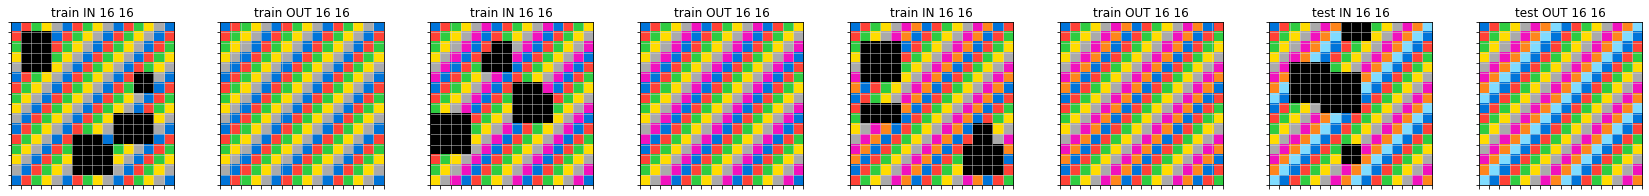

In [10]:
plot_task(train_tasks['c3f564a4'])

In [11]:
img = train_tasks['c3f564a4']['train'][0]['input']
img

array([[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1],
       [2, 0, 0, 0, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2],
       [3, 0, 0, 0, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3],
       [4, 0, 0, 0, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4],
       [5, 0, 0, 0, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 0, 0, 5, 1],
       [2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 0, 0, 1, 2],
       [3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3],
       [4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4],
       [5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 0, 0, 0, 0, 4, 5],
       [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 0, 0, 0, 0, 5, 1],
       [2, 3, 4, 5, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
       [3, 4, 5, 1, 2, 3, 0, 0, 0, 0, 3, 4, 5, 1, 2, 3],
       [4, 5, 1, 2, 3, 4, 0, 0, 0, 0, 4, 5, 1, 2, 3, 4],
       [5, 1, 2, 3, 4, 5, 0, 0, 0, 0, 5, 1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1]])

In [12]:
img_fts = parse_image_for_clusters(img)
img_fts

row  column  color
0      0       0      1
1      0       1      2
2      0       2      3
3      0       3      4
4      0       4      5
..   ...     ...    ...
251   15      11      2
252   15      12      3
253   15      13      4
254   15      14      5
255   15      15      1

[256 rows x 3 columns]

In [18]:
clustering = optics(min_samples=3).fit(img_fts)
clabs = clustering.labels_
clabs.shape = img.shape
clabs

array([[ 0,  0,  0,  0,  0, -1, -1, -1, -1, -1,  2,  2,  2,  2,  2,  3],
       [ 0,  1,  1,  1, -1, -1, -1, -1, -1,  2,  2,  2,  2,  2,  3,  3],
       [ 0,  1,  1,  1, -1, -1, -1, -1,  2,  2,  2,  2,  2,  3,  3,  3],
       [ 0,  1,  1,  1, -1, -1, -1,  2,  2,  2,  2,  2,  3,  3,  3,  3],
       [ 0,  1,  1,  1, -1, -1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3],
       [-1, -1, -1, -1, -1,  2,  2,  2,  2,  2,  3,  3,  4,  4,  3, -1],
       [-1, -1, -1, -1,  2,  2,  2,  2,  2,  3,  3,  3,  4,  4, -1, -1],
       [-1, -1, -1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3, -1, -1, -1],
       [-1, -1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3, -1, -1, -1, -1],
       [-1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  5,  5,  5,  5, -1, -1],
       [ 2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  5,  5,  5,  5, -1, -1],
       [ 2,  2,  2,  2,  3,  3,  6,  6,  6, -1,  5,  5,  5,  5, -1, -1],
       [ 2,  2,  2,  3,  3,  3,  6,  6,  6,  6,  7,  7,  7, -1, -1, -1],
       [ 2,  2,  3,  3,  3,  3,  6,  6,  6,  6,  7,